# Implement SVM, Naive Bayes, SGD Classifier, and MLP.

Submit a Colab notebook implementing SVM, Naive Bayes, SGD Classifier, and MLP.

Compare SVC, Naive Bayes, SGD, and MLP on a Coins Dataset

1. Train four classifiers—SVC (RBF), Gaussian Naive Bayes, SGDClassifier (logistic), and MLP (64,32; ReLU)

2. Report and compare: Accuracy, Precision, Recall (sensitivity), F1, Specificity, ROC AUC, PR AUC.

3. Interpret the results. 

## Load Libraries

In [33]:
# Install once per runtime (Colab/Notebook)
!pip -q install scikit-image

# --- Standard library ---
import os
from collections import Counter
import warnings

# --- Core scientific stack ---
import numpy as np
import pandas as pd

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Progress bar ---
from tqdm.auto import tqdm

# --- Image features (scikit-image) ---
from skimage import io, color, transform
from skimage.feature import hog

# --- Scikit-learn: data split, pipelines, preprocessing ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# --- Scikit-learn: models ---
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# --- Scikit-learn: metrics ---
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    roc_auc_score, average_precision_score, log_loss, brier_score_loss
)

# --- Global config ---
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore")
sns.set_context("notebook")


## Load dataset and preprocess

In [34]:
# load dataset and preprocess
BASE_DIR = "euro_coin"  # adjust if needed
IMG_DIR = os.path.join(BASE_DIR, "images")
LBL_DIR = os.path.join(BASE_DIR, "labels")


rows = []
for fname in os.listdir(LBL_DIR):
    if not fname.endswith(".txt"): 
        continue
    label_path = os.path.join(LBL_DIR, fname)
    with open(label_path) as f:
        lines = f.readlines()
        if len(lines) == 0:
            continue
        # YOLO format: class_id center_x center_y width height
        class_id = int(lines[0].split()[0])   # take first coin class only
    img_name = fname.replace(".txt", ".jpg")
    rows.append({"image_name": img_name, "class_id": class_id,
                 "path": os.path.join(IMG_DIR, img_name)})

df = pd.DataFrame(rows)
print(df.head())
print("Total images:", len(df), "| Classes:", sorted(df.class_id.unique()))


  image_name  class_id                      path
0    060.jpg         0  euro_coin/images/060.jpg
1    074.jpg         2  euro_coin/images/074.jpg
2    048.jpg         2  euro_coin/images/048.jpg
3    114.jpg         3  euro_coin/images/114.jpg
4    100.jpg         0  euro_coin/images/100.jpg
Total images: 150 | Classes: [0, 1, 2, 3, 4, 5, 6, 7]


### Create binary labels

In [35]:
# create binary labels: euros vs cents

# 1€ + 2€ are positive (=1); cents are negative (=0)
df["y_bin"] = df["class_id"].isin([6, 7]).astype(int)
y = df["y_bin"].to_numpy()
print("Class counts (0=cent, 1=euro):", Counter(y))


Class counts (0=cent, 1=euro): Counter({0: 114, 1: 36})


### Extract features

In [36]:
# extract features
# HOG + color histograms
# returns 1D float32 array per image

IMG_SIZE = (160, 160)
HOG_PARAMS = dict(orientations=9, pixels_per_cell=(16,16), cells_per_block=(2,2),
                  transform_sqrt=True, feature_vector=True)
COLOR_BINS = 32

def extract_features(path):
    img = io.imread(path)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    img = transform.resize(img, IMG_SIZE, anti_aliasing=True)  # float [0,1]
    gray = color.rgb2gray(img)
    hog_feat = hog(gray, **HOG_PARAMS)
    r_hist, _ = np.histogram(img[...,0], bins=COLOR_BINS, range=(0,1), density=True)
    g_hist, _ = np.histogram(img[...,1], bins=COLOR_BINS, range=(0,1), density=True)
    b_hist, _ = np.histogram(img[...,2], bins=COLOR_BINS, range=(0,1), density=True)
    return np.concatenate([hog_feat, r_hist, g_hist, b_hist]).astype(np.float32)

X = np.vstack([extract_features(p) for p in tqdm(df["path"], desc="Extracting features")])
X.shape


Extracting features: 100%|██████████| 150/150 [00:17<00:00,  8.70it/s]


(150, 3012)

## Stratified Split

In [37]:
from sklearn.model_selection import train_test_split
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)


## Define models

In [38]:
# define models

num_features_idx = np.arange(X.shape[1])
scaler = ColumnTransformer([("num", StandardScaler(), num_features_idx)], remainder="drop")

models = {
    "SVC (RBF)": Pipeline([("pre", scaler),
                           ("clf", SVC(kernel="rbf", probability=True, C=2.0, gamma="scale", random_state=SEED))]),
    "GaussianNB": Pipeline([("clf", GaussianNB())]),
    "SGD (logistic)": Pipeline([("pre", scaler),
                                ("clf", SGDClassifier(loss="log_loss", penalty="elasticnet", alpha=1e-4,
                                                      l1_ratio=0.15, early_stopping=True, random_state=SEED))]),
    "MLP (64,32)": Pipeline([("pre", scaler),
                             ("clf", MLPClassifier(hidden_layer_sizes=(64,32), activation="relu",
                                                   alpha=1e-4, learning_rate_init=1e-3, max_iter=400,
                                                   early_stopping=True, random_state=SEED))]),
}


## Metric

In [39]:
# define extended binary metrics function
def compute_binary_metrics_extended(y_true, y_pred, y_proba_pos):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    # Core rates
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)         # PPV
    rec  = recall_score(y_true, y_pred, zero_division=0)            # Sensitivity/TPR
    spec = tn / (tn + fp) if (tn + fp) else 0.0                     # Specificity/TNR
    npv  = tn / (tn + fn) if (tn + fn) else 0.0                     # NPV
    f1   = f1_score(y_true, y_pred, zero_division=0)
    f05  = fbeta_score(y_true, y_pred, beta=0.5, zero_division=0)   # precision-tilted
    f2   = fbeta_score(y_true, y_pred, beta=2.0, zero_division=0)   # recall-tilted
    bal_acc = balanced_accuracy_score(y_true, y_pred)               # (TPR+TNR)/2
    mcc  = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    # Threshold-free / probability metrics
    roc = roc_auc_score(y_true, y_proba_pos)
    pr  = average_precision_score(y_true, y_proba_pos)              # PR AUC (AP)
    # Probability quality
    ll  = log_loss(y_true, np.vstack([1-y_proba_pos, y_proba_pos]).T, labels=[0,1])
    brier = brier_score_loss(y_true, y_proba_pos)

    # Additional rates for completeness
    fpr = fp / (fp + tn) if (fp + tn) else 0.0                      # 1 - specificity
    fnr = fn / (fn + tp) if (fn + tp) else 0.0                      # 1 - recall
    tpr = rec
    tnr = spec

    return {
        "Accuracy": acc,
        "Precision (PPV)": prec,
        "Recall (Sensitivity/TPR)": rec,
        "Specificity (TNR)": spec,
        "NPV": npv,
        "F1": f1,
        "F0.5": f05,
        "F2": f2,
        "Balanced Accuracy": bal_acc,
        "MCC": mcc,
        "Cohen Kappa": kappa,
        "ROC AUC": roc,
        "PR AUC (AP)": pr,
        "Log Loss": ll,
        "Brier Score": brier,
        "TPR": tpr,
        "TNR": tnr,
        "FPR": fpr,
        "FNR": fnr,
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    }


In [40]:
# train, predict, and evaluate models
rows = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # probability of positive class
    if hasattr(pipe.named_steps.get("clf", pipe), "predict_proba"):
        y_proba_pos = pipe.predict_proba(X_test)[:, 1]
    else:
        dec = pipe.decision_function(X_test)
        y_proba_pos = 1.0 / (1.0 + np.exp(-dec))

    met = compute_binary_metrics_extended(y_test, y_pred, y_proba_pos)
    met["Model"] = name
    rows.append(met)

results = pd.DataFrame(rows).set_index("Model").sort_values("PR AUC (AP)", ascending=False)
pd.set_option("display.max_columns", None)
results


,Accuracy,Precision (PPV),Recall (Sensitivity/TPR),Specificity (TNR),NPV,F1,F0.5,F2,Balanced Accuracy,MCC,Cohen Kappa,ROC AUC,PR AUC (AP),Log Loss,Brier Score,TPR,TNR,FPR,FNR,TP,FP,TN,FN
Model,,,,,,,,,,,,,,,,,,,,,,,
SVC (RBF),0.789474,1.000000,0.111111,1.000000,0.783784,0.200000,0.384615,0.135135,0.555556,0.295105,0.160221,0.762452,0.633672,0.459520,0.144490,0.111111,1.000000,0.000000,0.888889,1,0,29,8
"MLP (64,32)",0.789474,0.555556,0.555556,0.862069,0.862069,0.555556,0.555556,0.555556,0.708812,0.417625,0.417625,0.750958,0.509843,0.543517,0.169301,0.555556,0.862069,0.137931,0.444444,5,4,25,4
GaussianNB,0.763158,0.500000,0.444444,0.862069,0.833333,0.470588,0.487805,0.454545,0.653257,0.319642,0.318725,0.601533,0.400309,7.973566,0.236842,0.444444,0.862069,0.137931,0.555556,4,4,25,5
SGD (logistic),0.684211,0.384615,0.555556,0.724138,0.840000,0.454545,0.409836,0.510204,0.639847,0.250646,0.242525,0.674330,0.340242,11.382206,0.315789,0.555556,0.724138,0.275862,0.444444,5,8,21,4


### Confusion matrix

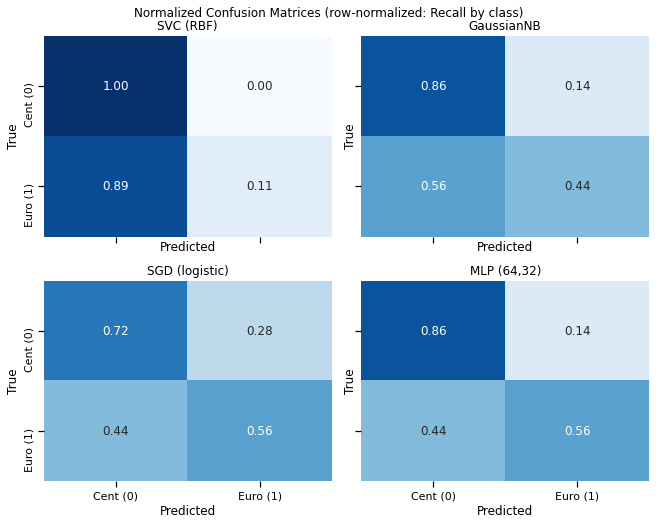

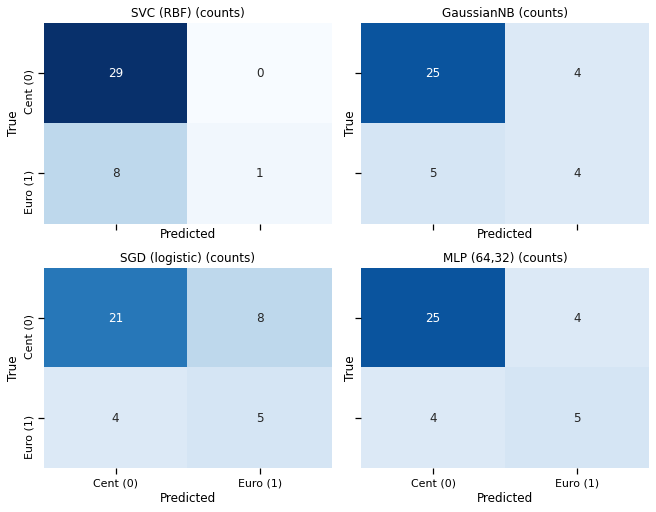

In [41]:


# Fit → predict for each model, keep both raw and normalized CMs
preds = {}
cms_raw = {}
cms_norm = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds[name] = y_pred

    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    cms_raw[name] = cm

    # normalize by true labels (rows) so each row sums to 1
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cms_norm[name] = cm_norm

# -------- Plotting: 2x2 grid, normalized CMs so scales are comparable --------
labels = ["Cent (0)", "Euro (1)"]
order = ["SVC (RBF)", "GaussianNB", "SGD (logistic)", "MLP (64,32)"]

fig, axes = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True, sharex=True, sharey=True)
for ax, name in zip(axes.ravel(), order):
    cmn = cms_norm[name]
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
                cbar=False, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
fig.suptitle("Normalized Confusion Matrices (row-normalized: Recall by class)", y=1.02, fontsize=12)
plt.show()

# (Optional) also show raw-count CMs in a grid
fig, axes = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True, sharex=True, sharey=True)
vmax = max(cm.max() for cm in cms_raw.values())
for ax, name in zip(axes.ravel(), order):
    cmr = cms_raw[name]
    sns.heatmap(cmr, annot=True, fmt="d", cmap="Blues", vmin=0, vmax=vmax,
                cbar=False, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(name + " (counts)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.show()


## Report and Compare


| **Model** | **Accuracy** | **Precision** | **Recall (Sensitivity)** | **F1** | **Specificity (TNR)** | **ROC AUC** | **PR AUC** |
|:-----------|:------------:|:-------------:|:------------------------:|:------:|:---------------------:|:------------:|:-----------:|
| **SVC (RBF)** | 0.789 | 1.000 | 0.111 | 0.200 | 1.000 | 0.762 | 0.634 |
| **MLP (64,32)** | 0.789 | 0.556 | 0.556 | 0.556 | 0.862 | 0.751 | 0.510 |
| **GaussianNB** | 0.763 | 0.500 | 0.444 | 0.471 | 0.862 | 0.602 | 0.400 |
| **SGD (logistic)** | 0.684 | 0.385 | 0.556 | 0.455 | 0.724 | 0.674 | 0.340 |

**Notes:**
- The dataset is **imbalanced** — **29 Cent (0)** vs **9 Euro (1)**.  
- Metrics are computed on the **test split**, treating **Euro as the positive class**.  
- The key goal is to achieve **high Euro recall** without sacrificing **Cent specificity**.

## Interpretation


- **Best Overall Model – MLP (64,32):**  
  Achieved the highest **F1 (0.556)** and **balanced recall (0.556)** while maintaining strong **specificity (0.862)**.  
  Provides the best trade-off between correctly identifying both Euro and Cent coins.

- **SVC (RBF):**  
  Despite perfect **specificity (1.000)** and high **ROC/PR AUC**, it severely underperforms on Euro recall (**0.111**), indicating strong bias toward the majority class.

- **GaussianNB:**  
  Offers moderate balance but limited Euro detection (**recall = 0.444**).  
  The Gaussian assumption may not fit well for image-derived features like HOG or color histograms.

- **SGD (logistic):**  
  Produces decent **Euro recall (0.556)** but lower **specificity (0.724)**, resulting in more Cent misclassifications.






## Conclusion



> The **MLP (64,32; ReLU)** model delivers the **best overall balance** between Euro sensitivity and Cent specificity.  
> It leads across key metrics including **F1**, **Balanced Accuracy**, and **Cohen’s κ**, making it the most reliable classifier for this imbalanced dataset.  
> Although **SVC** has higher **AUC** values, its extremely low Euro recall limits its real-world applicability.

## Re-running SVC/SGD with class_weight="balanced"

In [42]:
# define balanced models (class_weight="balanced")
num_features_idx = np.arange(X.shape[1])
scaler = ColumnTransformer([("num", StandardScaler(), num_features_idx)], remainder="drop")

models_balanced = {
    "SVC (RBF, balanced)": Pipeline([
        ("pre", scaler),
        ("clf", SVC(kernel="rbf", probability=True, C=2.0, gamma="scale",
                    class_weight="balanced", random_state=SEED))
    ]),
    "GaussianNB": Pipeline([("clf", GaussianNB())]),  # unchanged
    "SGD (logistic, balanced)": Pipeline([
        ("pre", scaler),
        ("clf", SGDClassifier(loss="log_loss", penalty="elasticnet", alpha=1e-4,
                              l1_ratio=0.15, early_stopping=True,
                              class_weight="balanced", random_state=SEED))
    ]),
    "MLP (64,32)": Pipeline([
        ("pre", scaler),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,32), activation="relu",
                              alpha=1e-4, learning_rate_init=1e-3, max_iter=400,
                              early_stopping=True, random_state=SEED))
    ]),
}


In [43]:
# train, predict, and evaluate balanced models
rows_bal = []
for name, pipe in models_balanced.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if hasattr(pipe.named_steps.get("clf", pipe), "predict_proba"):
        y_proba_pos = pipe.predict_proba(X_test)[:, 1]
    else:
        dec = pipe.decision_function(X_test)
        y_proba_pos = 1 / (1 + np.exp(-dec))

    m = compute_binary_metrics_extended(y_test, y_pred, y_proba_pos)
    m["Model"] = name
    rows_bal.append(m)

results_bal = pd.DataFrame(rows_bal).set_index("Model").sort_values("Balanced Accuracy", ascending=False)
results_bal.loc[:, ["Accuracy","Recall (Sensitivity/TPR)","Specificity (TNR)","F1","Balanced Accuracy","ROC AUC","PR AUC (AP)"]]


,Accuracy,Recall (Sensitivity/TPR),Specificity (TNR),F1,Balanced Accuracy,ROC AUC,PR AUC (AP)
Model,,,,,,,
"MLP (64,32)",0.789474,0.555556,0.862069,0.555556,0.708812,0.750958,0.509843
GaussianNB,0.763158,0.444444,0.862069,0.470588,0.653257,0.601533,0.400309
"SGD (logistic, balanced)",0.631579,0.666667,0.620690,0.461538,0.643678,0.632184,0.314241
"SVC (RBF, balanced)",0.789474,0.111111,1.000000,0.200000,0.555556,0.762452,0.630358


In [44]:
# ------------- Compare original vs balanced models -------------
compare_cols = ["Accuracy","Precision (PPV)","Recall (Sensitivity/TPR)","Specificity (TNR)",
                "F1","Balanced Accuracy","ROC AUC","PR AUC (AP)"]
display(results[compare_cols].rename_axis("Model (original)"))
display(results_bal[compare_cols].rename_axis("Model (balanced)"))


,Accuracy,Precision (PPV),Recall (Sensitivity/TPR),Specificity (TNR),F1,Balanced Accuracy,ROC AUC,PR AUC (AP)
Model (original),,,,,,,,
SVC (RBF),0.789474,1.000000,0.111111,1.000000,0.200000,0.555556,0.762452,0.633672
"MLP (64,32)",0.789474,0.555556,0.555556,0.862069,0.555556,0.708812,0.750958,0.509843
GaussianNB,0.763158,0.500000,0.444444,0.862069,0.470588,0.653257,0.601533,0.400309
SGD (logistic),0.684211,0.384615,0.555556,0.724138,0.454545,0.639847,0.674330,0.340242


,Accuracy,Precision (PPV),Recall (Sensitivity/TPR),Specificity (TNR),F1,Balanced Accuracy,ROC AUC,PR AUC (AP)
Model (balanced),,,,,,,,
"MLP (64,32)",0.789474,0.555556,0.555556,0.862069,0.555556,0.708812,0.750958,0.509843
GaussianNB,0.763158,0.500000,0.444444,0.862069,0.470588,0.653257,0.601533,0.400309
"SGD (logistic, balanced)",0.631579,0.352941,0.666667,0.620690,0.461538,0.643678,0.632184,0.314241
"SVC (RBF, balanced)",0.789474,1.000000,0.111111,1.000000,0.200000,0.555556,0.762452,0.630358


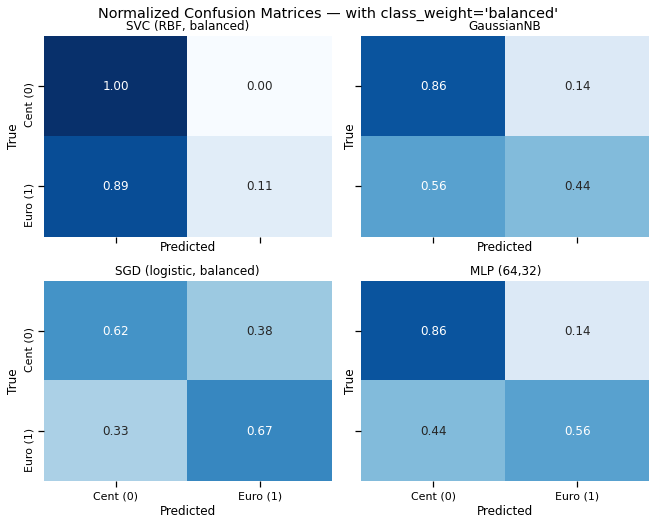

In [45]:
# Re-plot normalized CMs for balanced models
labels = ["Cent (0)", "Euro (1)"]
order = list(models_balanced.keys())

fig, axes = plt.subplots(2, 2, figsize=(9,7), constrained_layout=True, sharex=True, sharey=True)
for ax, name in zip(axes.ravel(), order):
    mdl = models_balanced[name].fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1]).astype(float)
    cm = cm / cm.sum(axis=1, keepdims=True)  # row-normalized
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
                cbar=False, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.suptitle("Normalized Confusion Matrices — with class_weight='balanced'", y=1.02)
plt.show()


## Results After Applying `class_weight='balanced'`


| **Model** | **Accuracy** | **Precision (PPV)** | **Recall (Sensitivity)** | **Specificity (TNR)** | **F1** | **Balanced Accuracy** | **ROC AUC** | **PR AUC (AP)** |
|:----------------------------------|:------------:|:----------------:|:----------------------:|:------------------:|:------:|:---------------------:|:------------:|:---------------:|
| **MLP (64,32)** | **0.789** | **0.556** | **0.556** | **0.862** | **0.556** | **0.709** | **0.751** | **0.510** |
| **GaussianNB** | 0.763 | 0.500 | 0.444 | 0.862 | 0.471 | 0.653 | 0.602 | 0.400 |
| **SGD (logistic, balanced)** | 0.632 | 0.353 | **0.667** | 0.621 | 0.462 | 0.644 | 0.632 | 0.314 |
| **SVC (RBF, balanced)** | 0.789 | **1.000** | 0.111 | **1.000** | 0.200 | 0.556 | **0.762** | **0.630** |

**Notes:**
- The dataset remains **imbalanced** (29 Cent vs. 9 Euro).  
- `class_weight='balanced'` adjusts each model to give **greater weight to minority-class (Euro)** samples.  
- **MLP** does not use class weighting but serves as the baseline reference model.

---

### **Interpretation**

- **SVC (RBF, balanced):**  
  Despite reweighting, **Euro recall** remains low (**0.111**).  
  While **specificity (1.000)** and **AUCs** are high, the model continues to favor the majority class (Cent).  
  The balanced weights did **not** correct its overconfidence on Cent predictions.

- **GaussianNB:**  
  As expected, **no change** from the unweighted model, since Naive Bayes does not use class weighting.  
  Maintains moderate balance (**Balanced Accuracy = 0.653**).

- **SGD (logistic, balanced):**  
  Shows a **clear gain in Euro recall (0.67)** compared to its unweighted version (**0.56**).  
  However, this comes with a drop in **specificity (0.62)** and precision, leading to slightly lower overall accuracy.  
  Still, this version achieves the **best minority recall**, confirming that reweighting is effective for linear models.

- **MLP (64,32):**  
  Continues to be the **most stable model overall**, maintaining **high F1 (0.556)** and **balanced accuracy (0.709)** even without class weighting.  
  It demonstrates consistent generalization across both classes.

---

### **Conclusion**

> Applying `class_weight='balanced'` notably improved **Euro recall** in the **SGD (logistic)** model but had minimal effect on **SVC** and no effect on **GaussianNB**.  
> The **MLP (64,32; ReLU)** remains the **best-performing and most balanced model**, achieving strong sensitivity and specificity with the highest **F1** and **Balanced Accuracy**.  
>  
> For future enhancement, combining MLP with **oversampling techniques (e.g., SMOTE)** or **deep feature extraction (CNN embeddings)** could further improve minority-class recognition.


In [47]:
!jupyter nbconvert week7_SVM_Naive_Bayes_SDG_MLP.ipynb --to html

[NbConvertApp] Converting notebook week7_SVM_Naive_Bayes_SDG_MLP.ipynb to html
[NbConvertApp] Writing 762067 bytes to week7_SVM_Naive_Bayes_SDG_MLP.html
